# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

**Modified:** y.-k kim<br>
**Modified Date:** 2020/07/24

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__


'2.4.0-dev20200721'

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [18]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


In [19]:
#!unzip -q kagglecatsanddogs_3367a.zip
#!ls


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [20]:
#!ls PetImages


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [21]:
import os

# Check the current working directory
display(os. getcwd())
folder_base_path="dataset\kagglecatsanddogs_3367a"

'C:\\Users\\ykkim\\Jupyter_ML_DL_Tutorial'

In [22]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(folder_base_path,"PetImages", folder_name)
    # listdir() returns a list containing the names of the entries in the directory given by path.
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        #display(fpath)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## Generate a `Dataset`


In [25]:
#This works only for  " TF-nightly".  TF2.2.0 does not work!!!

#tf.keras.preprocessing.image_dataset_from_directory(
#    directory, labels='inferred', label_mode='int', class_names=None,
#    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None,
#    validation_split=None, subset=None, interpolation='bilinear', follow_links=False)


data_path = os.path.join(folder_base_path,"PetImages")
display(data_path)

image_size = (180, 180)
batch_size = 16

#Divide 20
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.2,     #=0.8 for train, 0.2 for validation(testing) <-- How to set some data for dev? split again from test data
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,        
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


'dataset\\kagglecatsanddogs_3367a\\PetImages'

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


* Use this for TF2.2.0 or under <br>
    * Need to install cv2  imutils random  sklearn
    #pip install --upgrade imutils  <br>
    #pip install sklearn

    ```
    from imutils import build_montages
    from imutils import paths
    import random
    import cv2
    from sklearn.model_selection import train_test_split


    #initialize the data and labels
    print("[INFO] loading images...")

    image_size = (180, 180)
    batch_size = 32

    data = []
    labels = []

    data_path = os.path.join(folder_base_path,"PetImages")
    display(data_path)

    #grab the image paths and randomly shuffle them
    imagePaths = sorted(list(paths.list_images(data_path)))
    random.seed(42)
    random.shuffle(imagePaths)
    #loop over the input images
    for imagePath in imagePaths:
        # load the image, resize the image to be 32x32 pixels (ignoring
        # aspect ratio), flatten the image into 32x32x3=3072 pixel image
        # into a list, and store the image in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, image_size).flatten()
        data.append(image)
        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)

    #the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
    ```


## Visualize the data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"  and label 0 is "cat".

(16, 180, 180, 3)
<dtype: 'float32'>
(16,)
<dtype: 'int32'>


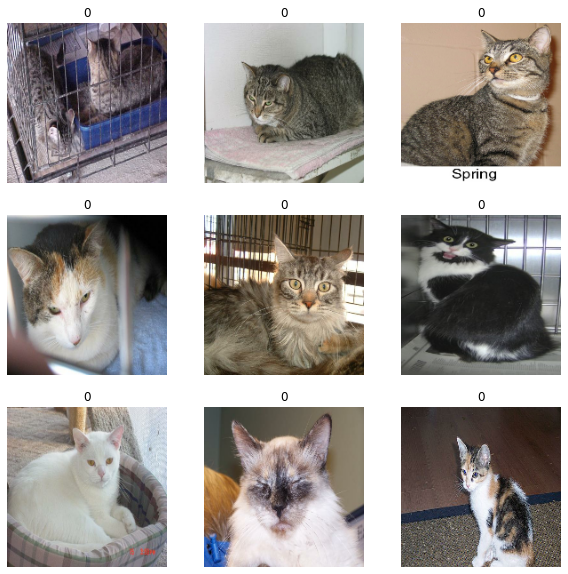

In [26]:
import matplotlib.pyplot as plt

#Creates a Dataset with batch=1
for images, labels in train_ds.take(1):   # taking one batch
        print(images.shape)  # (32=batch,180,180, channel=3)
        print(images.dtype)  # float32
        print(labels.shape)  # (32=batch
        print(labels.dtype)  # int32    
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [27]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


In [ ]:
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):        
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    

In [ ]:
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))       
    for i in range(9):
        ax2 = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
    # afer applying rot, flip   
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [28]:
# prefetch data to GPU
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [29]:
#  Small version of the Xception network. 

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # PREPROCESSING for Model Input
    # Image augmentation block with flip, rotation
    x = data_augmentation(inputs)
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    # Center-crop images to 180x180
    #x = layers.experimental.preprocessing.CenterCrop(height=180, width=180)(x)

    # Building Model
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)  # filter=32, kernelSize=3x3
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)





## Visualize the model

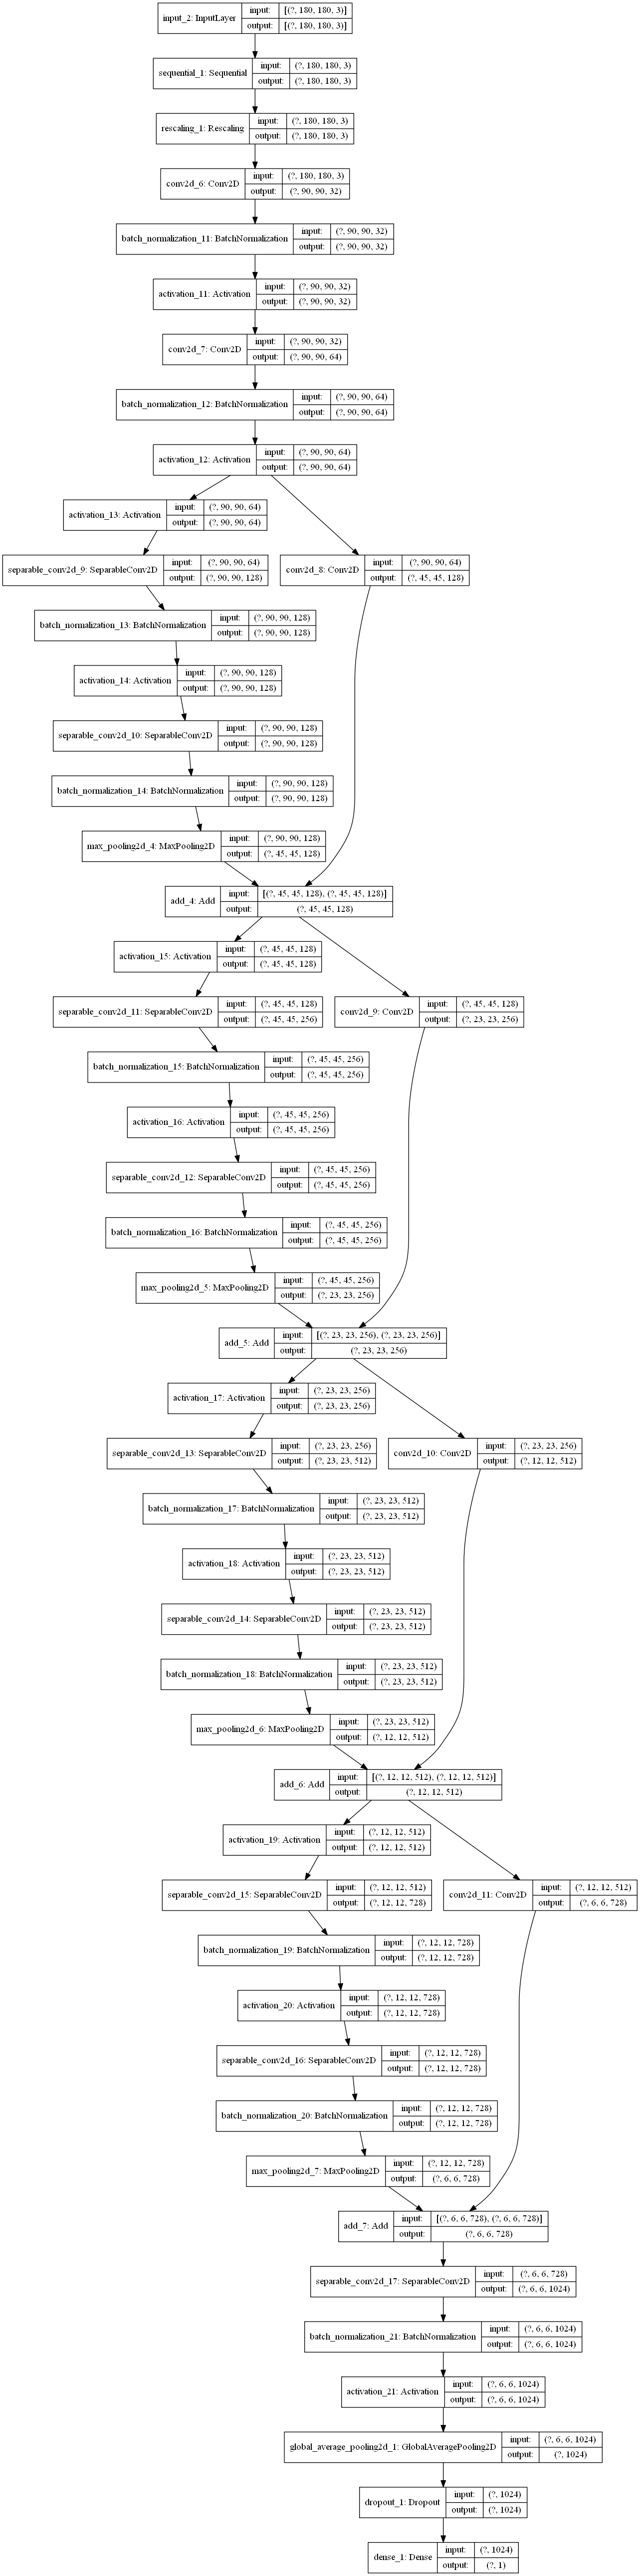

In [30]:
#  You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/)  for `pydotprint` to work
# https://bobswift.atlassian.net/wiki/spaces/GVIZ/pages/20971549/How+to+install+Graphviz+software

# for Conda, use the following
#conda install -c anaconda pydot


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model


In [31]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
1172/1172 [==============================] - 740s 631ms/step - loss: 0.6378 - accuracy: 0.6500 - val_loss: 0.5107 - val_accuracy: 0.7622
Epoch 2/50
1172/1172 [==============================] - 727s 620ms/step - loss: 0.4953 - accuracy: 0.7630 - val_loss: 0.4467 - val_accuracy: 0.7923
Epoch 3/50
1172/1172 [==============================] - 721s 615ms/step - loss: 0.4057 - accuracy: 0.8194 - val_loss: 1.8758 - val_accuracy: 0.5726
Epoch 4/50
1172/1172 [==============================] - 709s 605ms/step - loss: 0.3458 - accuracy: 0.8520 - val_loss: 0.2955 - val_accuracy: 0.8766
Epoch 5/50
1172/1172 [==============================] - 703s 599ms/step - loss: 0.2876 - accuracy: 0.8784 - val_loss: 0.2977 - val_accuracy: 0.8811
Epoch 6/50
1172/1172 [==============================] - 741s 633ms/step - loss: 0.2515 - accuracy: 0.8952 - val_loss: 0.2381 - val_accuracy: 0.9084
Epoch 7/50
1172/1172 [==============================] - 719s 614ms/step - loss: 0.2332 - accuracy: 0.9004 - val_

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


'dataset\\kagglecatsanddogs_3367a\\PetImages/Cat/6779.jpg'

(180, 180)

TensorShape([1, 180, 180, 3])

array([[0.07332133]], dtype=float32)

array([0.07332133], dtype=float32)

This image is 92.67 percent cat and 7.33 percent dog.


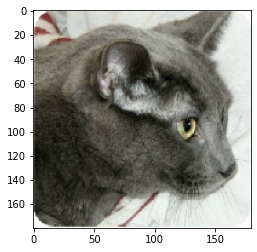

In [51]:
display(data_path+"/Cat/6779.jpg")

#Load and Plot image in Keras - PIL image
img = keras.preprocessing.image.load_img(
    data_path+"/Cat/6779.jpg", target_size=image_size, grayscale=False
)
display(img.size)
img.show()

#Convert PIL image into Numpy Array  
img_array = keras.preprocessing.image.img_to_array(img)
plt.imshow(img_array.astype("uint8"))

# Reshape NumpyArray to  Model input size (batchx180x180x3)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
display(img_array.shape)

predictions = model.predict(img_array)
score = predictions[0]
display(score)  #in error (1-accuracy)

#print format: e.g.  print("pi=%s" % "3.14159")
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


## How to save and load Model in Keras

*** Loading gives error issues. Need to check!!!.  
Instead, save and load model&weight separately ***

In [ ]:
# save model and architecture to single file
model.save("model_weight_xception_catdog.h5")
print("Saved model to disk")

from keras.models import load_model
# load model
model_load = load_model("model_weight_xception_catdog.h5")
# summarize model.
model_load.summary()

## How to save model(json) and weight separately in Keras

### Save model and weight

In [57]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model_xception_catdog.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("weight_xception_catdog.h5")
print("Saved model to disk")
 



Saved model to disk


### Load model and weight

In [64]:
with open('model_xception_catdog.json','r') as f:    
    loaded_model = tf.keras.models.model_from_json(f.read())
loaded_model.load_weights("weight_xception_catdog.h5")

print("Loaded model from disk")

    **This Code of 'loading Model' gives error. Do not use below code**

```
#load json and create model
json_file = open('model_xception_catdog.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
```

### Predict with loaded model and weigth

In [65]:
predictions = loaded_model.predict(img_array)
score = predictions[0]
display(score)  #in error (1-accuracy)

#print format: e.g.  print("pi=%s" % "3.14159")
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


array([0.07332133], dtype=float32)

This image is 92.67 percent cat and 7.33 percent dog.
